In [3]:
# Import base librairies
import sys
import os
import json
from pathlib import Path
import time

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

# Import scikit-learn
from sklearn.utils import class_weight

# Check running environment
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running on Colab")
    
    # Mount google drive
    mounting_point = "/content/drive/"
    drive.mount(mounting_point, force_remount=True)

    # Add project directory to kernel paths
    drive_folder = "MyDrive/pneumonia_detection/T-DEV-810-PAR_10"
    
    sys.path.append(mounting_point + drive_folder)
else:
    print("We're running localy")
    
    # Add project directory to kernel paths
    sys.path.append('../../')

We're running localy


In [4]:
# Import custom functions

from src.data.file_manager import FileManager
from src.data.tf_utils import load_image_dataset_from_tfrecord, define_distribute_strategy
from src.data.evaluation import Evaluation

zoidbergManager = FileManager()
strategy = define_distribute_strategy()
evaluation = Evaluation(strategy)

# Set default graphics visualization
%matplotlib inline

Selected distribution strategy:                     _DefaultDistributionStrategy


2023-05-15 13:43:49.531285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# set random seed for keras, numpy, tensorflow, and the 'random' module
SEED = 42
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ***2. Loading dataset*** *texte en italique*

In [6]:
BATCH_SIZE = 64
SMALL_TRAIN_SPLIT = 0.20
SMALL_VAL_SPLIT = 0.15
class_names = ['bacteria', 'normal', 'virus']

First, let's load the train and val datasets

In [7]:
processed_dir_path = zoidbergManager.data_dir / 'processed'
print(processed_dir_path)

train_path = str(processed_dir_path / 'train_512x512_rgb_ds.tfrecord')
val_path = str(processed_dir_path / 'val_512x512_rgb_ds.tfrecord')

train_ds = load_image_dataset_from_tfrecord(train_path)
val_ds = load_image_dataset_from_tfrecord(val_path)

/home/dylan/Desktop/Pneumonia/pneumonia_detection/pneumonia/notebooks/models/../../data/processed


Then, we extract a small part of each datasets to train each models on a small dataset.


In [8]:
num_train_img = train_ds.reduce(0, lambda x, _: x + 1).numpy()
num_val_img = val_ds.reduce(0, lambda x, _: x + 1).numpy()

# Shuffle data
train_ds = train_ds.shuffle(buffer_size=num_train_img, seed=42)
val_ds = val_ds.shuffle(buffer_size=num_val_img, seed=42)

# Extract a sample
small_train_size = int(num_train_img * SMALL_TRAIN_SPLIT)
small_val_size = int(num_val_img * SMALL_VAL_SPLIT)

small_train_ds = train_ds.take(small_train_size)
small_val_ds = val_ds.take(small_val_size)

def count_img_by_class(dataset, class_names=class_names):
    num_img_by_classes = {name:0 for name in class_names}
    for images, labels in dataset:
        idx_label = np.nonzero(labels.numpy())[0][0]
        for idx, name in enumerate(class_names):
            if idx_label == idx:
                num_img_by_classes[name] += 1
    return num_img_by_classes

print("In training dataset, there are :")
for class_name, num_img in count_img_by_class(small_train_ds).items():
    print(f"  - {num_img} files for class {class_name}")    
print("\nIn val dataset, there are :")
for class_name, num_img in count_img_by_class(small_val_ds).items():
    print(f"  - {num_img} files for class {class_name}")

2023-05-15 13:43:50.459647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-15 13:43:57.869262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In training dataset, there are :


2023-05-15 13:43:58.559912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-15 13:43:58.560831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-15 13:44:08.599793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4482 of 4685
2023-05-15 13:44:09.038819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


  - 453 files for class bacteria
  - 237 files for class normal
  - 247 files for class virus

In val dataset, there are :


2023-05-15 13:44:09.554639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-15 13:44:09.555371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


  - 20 files for class bacteria
  - 11 files for class normal
  - 12 files for class virus


In [9]:
# Batch & prefecth data to improve computation time
small_train_ds = small_train_ds.batch(BATCH_SIZE).prefetch(
    buffer_size=tf.data.AUTOTUNE)

small_val_ds = small_val_ds.batch(BATCH_SIZE).prefetch(
    buffer_size=tf.data.AUTOTUNE)

3. Compare a bunch of bunch of models

Let's now train models on this small dataset. We set useful variables below.

⚠️⚠️⚠️ WARNING : Depending on your hardware, training cells can be computationally expensive and take a really long time to run them !!!
That's why each of these cells are wrapped in a if condition (see TRAIN_*MODEL* booleans below).

In [10]:
EPOCHS = 30
LEARNING_RATE = 0.0001

TRAIN_VGG16 = False
TRAIN_RESNET50 = False
TRAIN_INCEPTION_RESNET = False
TRAIN_XCEPTION = False
TRAIN_EFFICIENTNETB0 = False

We define also 2 callbacks :

checkpoint_cb : save model at each epoch (only save best weight).
earlystopping_cb : stop training if model does not progress. It is faster and helps against overfitting.

def checkpoint_cb(model):
    checkpoint_dir = zoidbergManager.model_dir / 'checkpoints'
    checkpoint_filepath = checkpoint_dir / f'ckpt_smallds_{model.name}.h5'
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_CKS',
        mode='max',
        save_best_only=True
    )
    return ckpt_cb

Why use compute_class_weight() ?
https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl



Next, we compute class weights to prevent imbalanced classes (as we saw when we analyzed data) :



In [11]:
y_train_iterator = train_ds.map(lambda x, y: y).as_numpy_iterator()
y_train = []
for one_vector in y_train_iterator:
    y_train.append(one_vector)
y_train = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights
dic_class_weights = {}
for idx, weight in enumerate(class_weights):
    dic_class_weights[idx] = weight
    print(f'class {class_names[idx]} => weight : {weight:2f}')

2023-05-15 13:44:10.659988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-15 13:44:10.661366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


class bacteria => weight : 0.693458
class normal => weight : 1.248335
class virus => weight : 1.321207


The save_history function is used to save the training history of a model, along with additional information such as the total training time and average epoch time. Here's a breakdown of the function:
In summary, the save_history function saves the training history, training time, and average epoch time of a model in a JSON file for future reference or analysis.


The train_model function is used to train a given model using the specified data and settings. Here's an explanation of the function:  
It trains the model using the fit method, specifying the following:

small_train_ds: The training dataset.
small_val_ds: The validation dataset.
epochs: The number of training epochs.
class_weight: The class weights to be applied during training to handle class imbalance.
callbacks: Any additional callbacks to be used during training. In this case, it includes a checkpoint_cb callback, which is not defined in the given code snippet.


In [12]:
def save_history(model, history, training_time):
    dic = {}
    dic['history'] = history.history
    dic['training_time'] = training_time
    dic['epoch_time'] = training_time/len(history.history['loss'])
    history_dir = zoidbergManager.model_dir / 'histories'
    history_filepath = history_dir / f'hty_smallds_{model.name}.json'
    json.dump(dic, open(history_filepath, 'w'))

def train_model(model, save=False):
    start_time = time.time()
    history = model.fit(small_train_ds,
                        validation_data=small_val_ds,
                        epochs=EPOCHS,
                        class_weight=dic_class_weights,
                        callbacks=[checkpoint_cb(model)],
                        )
    training_time = time.time() - start_time

    if save:
        save_history(model, history, training_time)

    return history, training_time

We selected 4 kinds of models to try. Those models have been chosen base on their performance :

VGG and ResNet have been used several times on this dataset with some good performances. Many notebooks can be found on kaggle
Xception and EfficientNet have good results on imagenet with few parameters.
One can check performance of each model on imagenet here : keras.applications

We chose them here :
https://keras.io/api/applications/

3.1 VGG

In [13]:
def make_vgg16():
    base_vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
    for layer in base_vgg16.layers:
        layer.trainable = False
    
    vgg16 = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(224, 224, interpolation="bilinear", name='resize'),
        keras.layers.Rescaling(scale=1./255., name='rescale'),
        base_vgg16,
        keras.layers.Flatten(name='flatten'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1'),
        keras.layers.Dense(512, activation='relu', name='fully_conn2'),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name = 'vgg16')

    vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return vgg16
    
with strategy.scope():
    vgg16 = make_vgg16()

In [14]:
if TRAIN_VGG16:
    vgg16_history, vgg16_time = train_model(vgg16, save=True)

3.2 ResNet

In [15]:
def make_resnet50():
    base_resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False)
    for layer in base_resnet50.layers:
        layer.trainable = False
    
    resnet50 = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(224, 224, interpolation="bilinear", name='resize'),
        keras.layers.Rescaling(scale=1./255., name='rescale'),
        base_resnet50,
        keras.layers.GlobalAveragePooling2D(name='avg_pool'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1'),
        keras.layers.Dense(512, activation='relu', name='fully_conn2'),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name = 'resnet50')

    resnet50.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return resnet50
    
with strategy.scope():
    resnet50 = make_resnet50()

In [16]:
if TRAIN_RESNET50:
    resnet50_history, resnet50_time = train_model(resnet50, save=True)

In [17]:
def make_inception_resnet():
    base_inception_resnet = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape=(299,299,3), include_top=False)
    for layer in base_inception_resnet.layers:
        layer.trainable = False
    
    inception_resnet = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(299, 299, interpolation="bilinear", name='resize'),
        keras.layers.Rescaling(scale=1./255., name='rescale'),
        base_inception_resnet,
        keras.layers.GlobalAveragePooling2D(name='avg_pool'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1'),
        keras.layers.Dense(512, activation='relu', name='fully_conn2'),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name = 'inception_resnet')

    inception_resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return inception_resnet
    
with strategy.scope():
    inception_resnet = make_inception_resnet()

In [18]:
if TRAIN_INCEPTION_RESNET:
    inception_resnet_history, inception_resnet_time = train_model(inception_resnet, save=True)

*3.3 Xception*

In [19]:
def make_xception():
    base_xception = tf.keras.applications.Xception(weights='imagenet', input_shape=(299,299,3), include_top=False)
    for layer in base_xception.layers:
        layer.trainable = False
    
    xception = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(299, 299, interpolation="bilinear", name='resize'),
        keras.layers.Rescaling(scale=1./255., name='rescale'),
        base_xception,
        keras.layers.GlobalAveragePooling2D(name='avg_pool'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1'),
        keras.layers.Dense(512, activation='relu', name='fully_conn2'),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name = 'xception')

    xception.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return xception
    
with strategy.scope():
    xception = make_xception()

In [20]:
if TRAIN_XCEPTION:
    xception_history, xception_time = train_model(xception, save=True)

3.4 EfficientNet

In [21]:
def make_efficientnetb0():
    base_efficientnetb0 = tf.keras.applications.EfficientNetV2B0(weights='imagenet', input_shape=(224,224,3), include_top=False)
    for layer in base_efficientnetb0.layers:
        layer.trainable = False
    
    efficientnetb0 = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(512,512,3), name='input'),
        keras.layers.Resizing(224, 224, interpolation="bilinear", name='resize'),
        base_efficientnetb0,
        keras.layers.GlobalAveragePooling2D(name='avg_pool'),
        keras.layers.Dense(1024, activation='relu', name='fully_conn1'),
        keras.layers.Dense(512, activation='relu', name='fully_conn2'),
        keras.layers.Dense(3, activation='softmax', name='out_softmax'),
    ], name = 'efficientnetb0')

    efficientnetb0.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return efficientnetb0
    
with strategy.scope():
    efficientnetb0 = make_efficientnetb0()

In [22]:
if TRAIN_EFFICIENTNETB0:
    efficientnetb0_history, efficientnetb0_time = train_model(efficientnetb0, save=True)

3.5 Results

In [23]:
history_path = {
    'vgg16' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_vgg16.json',
    'resnet50' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_resnet50.json',
    'inception_resnet' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_inception_resnet.json',
    'xception' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_xception.json',
    'efficientnetb0' : zoidbergManager.model_dir / 'histories' / 'hty_smallds_efficientnetb0.json'
}

checkpoint_path = {
    'vgg16' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_vgg16.h5',
    'resnet50' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_resnet50.h5',
    'inception_resnet' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_inception_resnet.h5',
    'xception' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_xception.h5',
    'efficientnetb0' : zoidbergManager.model_dir / 'checkpoints' / 'ckpt_smallds_efficientnetb0.h5'
}

sumup_result_df = pd.DataFrame(columns=['model','size','training_time','max CKS','max val_CKS'])
histories = {}
# The for loop iterates over each model name and corresponding history path.
# It reads the training history from the JSON file and stores it in the histories dictionary.
for model_name, path in history_path.items():
    with open(path) as file:
# extracts the relevant information from the history 
        history = json.load(file)
    histories[model_name] = history['history']
# appends it to the sumup list.
    sumup = []
    sumup.append(model_name)
    sumup.append(f'{checkpoint_path[model_name].stat().st_size / (1e6):.1f} MB')
    sumup.append(f"{history['training_time']:.3f} s")
    sumup.append(f"{np.max(history['history']['CKS']):.3f}")
    sumup.append(f"{np.max(history['history']['val_CKS']):.3f}")
    idx_model = list(history_path.keys()).index(model_name)
    sumup_result_df.loc[idx_model] = sumup

sumup_result_df.head()

,model,size,training_time,max CKS,max val_CKS
0,vgg16,0.0 MB,118.330 s,0.855,0.894
1,resnet50,0.0 MB,109.166 s,0.857,0.802
2,inception_resnet,0.0 MB,165.964 s,0.700,0.796
3,xception,0.0 MB,123.148 s,0.762,0.818
4,efficientnetb0,0.0 MB,107.088 s,0.751,0.796


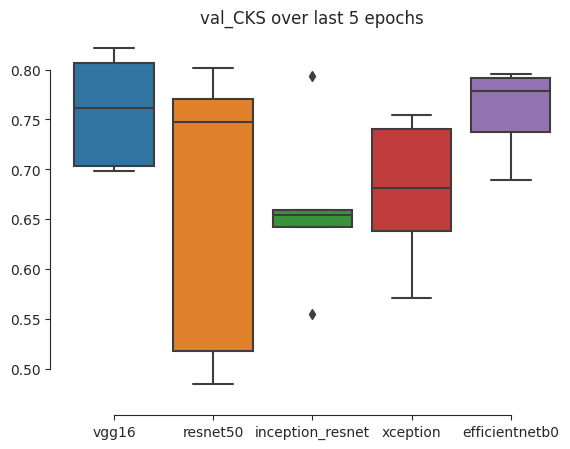

In [24]:
cks_history = {}
for model, history in histories.items():
    cks_history[model] = history['val_CKS']

sns.set_style('ticks')
bp = sns.boxplot(data=pd.DataFrame.from_dict(cks_history).iloc[-5:])
bp.set_title('val_CKS over last 5 epochs')
sns.despine(offset=10, trim=True)

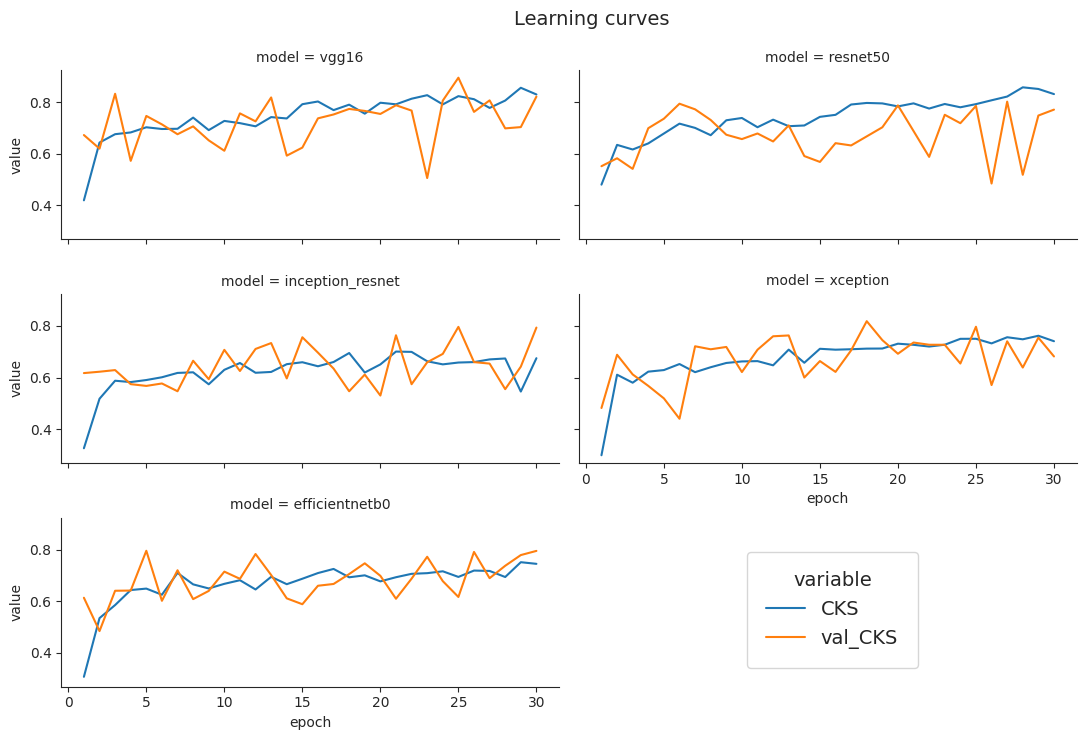

In [25]:
epochs = list(range(1,EPOCHS+1))
full_cks_history = []
for model, history in histories.items():
    data = {}
    data['epoch'] = epochs
    data['model'] = [model]*EPOCHS
    data['CKS'] = history['CKS']
    data['val_CKS'] = history['val_CKS']
    full_cks_history.append(pd.DataFrame.from_dict(data))
full_cks_history_df = pd.concat(full_cks_history)

sns.set_style('ticks')
rp = sns.relplot(
    data=pd.melt(full_cks_history_df,['epoch','model']),
    x="epoch",
    y="value",
    hue="variable",
    col="model",
    col_wrap=2,
    height=2.5,
    aspect=2.2,
    kind="line"
)
rp.fig.suptitle('Learning curves', fontsize=14)
rp.fig.subplots_adjust(top=0.9)
sns.move_legend(rp,
                'center',
                bbox_to_anchor=(.7, .18),
                fontsize=14,
                title_fontsize=14,
                frameon=True,
                borderpad=1)